In [1]:
import os
import random
from glob import glob

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms, models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [3]:
class DogCatDataset(Dataset):
    LABELS_DICT = {
        'dogs': 0,
        'cats': 1,
    }

    def __init__(self, path, lim=-1, aug=None):
        self.x = []
        self.y = []

        for label, val in self.LABELS_DICT.items():
            file_paths = glob(os.path.join(path, label, '*.jpg'))

            self.x.extend(file_paths)
            self.y.extend([val] * len(file_paths))

        shuffled_combined = list(zip(self.x, self.y))
        random.shuffle(shuffled_combined)
        self.x, self.y = zip(*shuffled_combined)

        self.x = self.x[:lim]
        self.y = self.y[:lim]

        self.aug = aug
        self.img_transform = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(224),
            transforms.ToTensor(),

            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, idx):
        x = Image.open(self.x[idx])
        x = self.img_transform(x)
        return x, torch.tensor(self.y[idx]).float().unsqueeze(-1)

    def __len__(self):
        return len(self.x)


train_dataset = DogCatDataset("data/cats_and_dogs_classification/training_set", lim=500)
val_dataset = DogCatDataset("data/cats_and_dogs_classification/test_set", lim=200)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [4]:
for param in resnet18_model.parameters():
    param.requires_grad = False

resnet18_model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.Sigmoid(),

    nn.Dropout(0.2),
    nn.Linear(256, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Linear(64, 1),
    nn.Sigmoid(),
)

summary(resnet18_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [5]:
def measure_accuracy(_y: torch.Tensor, y: torch.Tensor) -> float:
    return ((_y >= 0.5) == y).sum() / y.shape[0]

In [6]:
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(resnet18_model.parameters())

In [7]:
epochs = 5
trn_losses, trn_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(epochs):
    for x, y in train_dataloader:
        resnet18_model.train()
        resnet18_model.train()
        _y = resnet18_model(x)
        loss = criterion(_y, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        trn_losses.append(loss.item())
        trn_accuracies.append(measure_accuracy(_y, y))

        with torch.no_grad():
            resnet18_model.eval()
            resnet18_model.eval()
            for x_val, y_val in val_dataloader:
                _y_val = resnet18_model(x_val)
                loss_val = criterion(_y_val, y_val)

                val_losses.append(loss_val)
                val_accuracies.append(measure_accuracy(_y_val, y_val))

        print("done")
    print(f"Epoch: {epoch}, Trn Loss: {trn_losses[-1]}, Val Accuracy: {val_accuracies[-1]}")

done
done
done
done
done
done
done
done
Epoch: 0, Trn Loss: 0.6027176380157471, Val Accuracy: 0.875


KeyboardInterrupt: 

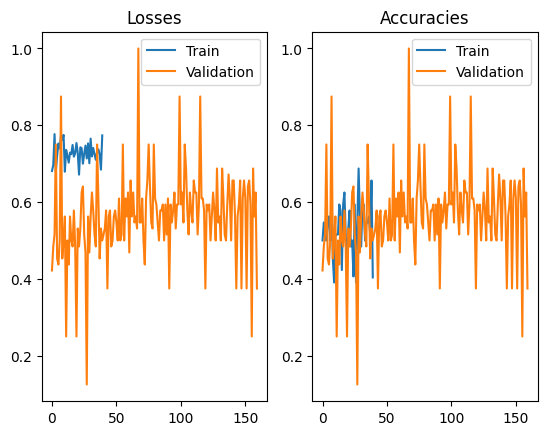

In [52]:
plt.subplot(121)
plt.title('Losses')
plt.plot(range(len(trn_losses)), trn_losses, label='Train')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation')
plt.legend()

plt.subplot(122)
plt.title('Accuracies')
plt.plot(range(len(trn_accuracies)), trn_accuracies, label='Train')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation')
plt.legend()